# Pregunta 2

In [1]:
from util import go_to_project_root
go_to_project_root()

CWD cambiado a la raíz del proyecto: /home/epsilon/Documents/doctorado/S2/ENSTA630/tareas/HW2


In [2]:
import numpy as np
import matplotlib.pyplot as plt 
import scipy.stats as stats
import statsmodels.distributions.empirical_distribution as ECDF

from source.data.transform import create_lagged_dataset
from source.fit.montecarlo import monte_carlo_mp
from source.fit.error import get_standard_error
from source.models.ar import AutoRegressive
from source.display.hw import hw1 as uplot
from source.models.ols import OLS
from source.statistics import calculate_autocovariance
from source.fit.inference import test_F

# from source.extention.pregunta2.source.models.autoregressive import AR
# from source.extention.pregunta2.source.models.Inferencia import Inferencia_OLS
# from source.extention.pregunta2.source.models.bootstrap import Bootstrap
# from source.extention.pregunta2.source.utils.criticos import valores_criticos
# from source.extention.pregunta2.source.utils.graficopdf import graficopdf
# from source.extention.pregunta2.source.utils.graficochow import graficochow

%load_ext autoreload
%autoreload 2

/home/epsilon/.conda/envs/macro/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
phi = [0.8, -0.2]
model = AutoRegressive(sigma=0.2, c=1, params_distribution=phi)
print(model)
model.get_autocovariance()

               AR(2) Model Summary                
Model Order              : 2
Intercept (c)            : 1
Error Std Dev (sigma)    : 0.2
Is Stationary            : True
Mu (Unc. Mean):          : 2.5
Sigma (Unc. Std.)        : 0.27
--------------------------------------------------
Coefficients (phi):
  phi_1    =  0.80
  phi_2    = -0.20


array([0.075, 0.05 ])

In [38]:
@monte_carlo_mp(n_iterations=1000, n_jobs=2)
def simulation_p2(iteration, n_samples, lags=1):
    phi = [0.8, -0.2]
    model = AutoRegressive(sigma=0.2, c=1, params_distribution=phi)
    X = model.sample(n_samples=n_samples+lags) # por el rezago
    # Calcular momentos
    moment_1 = np.mean(X)
    moment_2 = np.var(X)
    y_prev, y_curr = create_lagged_dataset(X, lag=lags, add_intercept=True)

    # OLS 
    ols_model = OLS()
    ols_model.fit(y_prev, y_curr)
    y_pred = ols_model.predict(y_prev)
    currsigma = get_standard_error(y_prev, y_pred, y_curr)

    # Test F 
    R = np.array([
        [1, 0, 0],
        [0, 1, 4]
    ])
    H0 = np.array([1, 0])
    f_stat, p_valor = test_F(ols_model, 
                             X=y_prev, 
                             y_true=y_curr, 
                             R=R, 
                             q=H0)
    
    return {'mean': moment_1, 
            "variance": moment_2, 
            "sigma_hat":currsigma,
            "f_stat": f_stat, 
            "p_valor": p_valor,
            "serie":X, 
            'y_prev':y_prev,
            'y_prev':y_prev} 

In [39]:
results = simulation_p2(n_samples=100, lags=2)

Iniciando simulación paralela con 1000 iteraciones en 2 procesos...


Simulación Monte Carlo: 100%|██████████| 1000/1000 [00:00<00:00, 1050.91it/s]


In [40]:
np.mean(results['mean']), np.mean(results['variance'])

(np.float64(2.5002108287702387), np.float64(0.07371935919748843))

In [41]:
model.extend_autocovariance(10)

array([ 7.500e-02,  5.000e-02,  2.500e-02,  1.000e-02,  3.000e-03,
        4.000e-04, -2.800e-04, -3.040e-04, -1.872e-04, -8.896e-05])

In [42]:
calculate_autocovariance(results['serie'][0], lag=10)

array([ 0.09498612,  0.06360747,  0.03251255,  0.00929678, -0.00430704,
       -0.01554857, -0.02128817, -0.01727341, -0.00771494,  0.00627576])

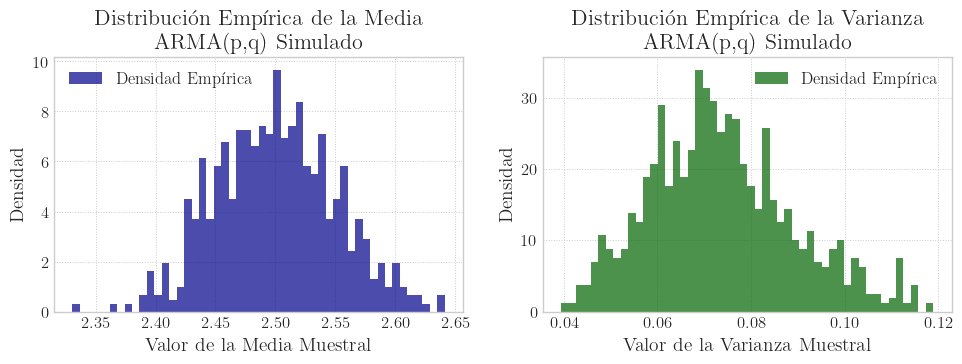

✅ Figura guardada exitosamente en ./presentation/figures/hw1/p2/densidades_1.pdf


In [43]:
# Parametros de la Distribución Empírica Acumulada ECDF
x1 = np.sort(results['mean'])  # Ordeno los datos
n = x1.size
y1 = np.arange(1, n+1) / n

# Parametros de la distribucion de la varianza
x2 = np.sort(results['variance'])  # Ordeno los datos
n = x2.size
y2 = np.arange(1, n+1) / n

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
# Parámetros de la Distribución F Acumulada
uplot.plot_empirical_distribution(
    mean_samples=results['mean'],
    var_samples=results['variance'],
    model_name="ARMA(p,q) Simulado",
    fig=fig,
    axes=axes
)

uplot.save_figure(fig, './presentation/figures/hw1/p2/densidades_1.pdf')

In [44]:
critic_value_1  = np.percentile(results['f_stat'], 99)
critic_value_5  = np.percentile(results['f_stat'], 95)
critic_value_10 = np.percentile(results['f_stat'], 90)

In [45]:
print("Valor crítico al 1%:", critic_value_1)
print("Valor crítico al 5%:", critic_value_5)
print("Valor crítico al 10%:", critic_value_10)

Valor crítico al 1%: 47.11387145082829
Valor crítico al 5%: 39.290093409699985
Valor crítico al 10%: 37.18809688223511
